In [1]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
# Make sure to have the font installed (it is on cluster for Harald)
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on HMS Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

compute-e-16-235.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 28
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


In [30]:
def load_qp_adm(path, infeasible=False):
    """Load, parse and return qp-Adm file.
    Return: 
    res: mxnx2 arryay: m: Nr subsets admixed pops, n: Nr 
    p_vals: List of m p-Values
    pops: List of Strings of analyzed populations. First is target, rest sources.
    infeasible: Whether to return infeasible as result"""
    
    pop_line, pop_line_end = -1, -1 # Where the populations are found   
    res_begin, res_end = -1, -1
    std_line = -1  # Where the standard Deviation will land
    
    # Iterate over everything and use the signals for start/stop
    with open(path, "r") as f:
        for i, line in enumerate(f):
            if line =="left pops:\n":
                pop_line = i+1 
            if line=="right pops:\n":
                pop_line_end = i-1 # There is an empty line before
                
            # Parse off everything to first space
            s0 = line.split()
            if len(s0)>=2:
                #if s0[0] == "summ:":
                #    res_begin= i+3
                if s0[0] == "fixed" and s0[1]=="pat":
                    res_begin = i+1
                    
                if s0[0] == "best" and s0[1]=="pat:":
                    if res_end < 0: # Only take the first occurence
                        res_end = i
                        
                elif s0[0] == "std." and s0[1]=="errors:":
                    std_line = i
    
    ### Read out the results:
    with open(path, "r") as f:
        lines = f.readlines()
        pops = lines[pop_line:pop_line_end]
        pops = [p.rstrip() for p in pops]  # Chews off new line symbol

        res = lines[res_begin:res_end]
        stds = lines[std_line]
    
    # Post-process the important Lines:
    res_t = np.array([s.split()[:len(pops)+4] for s in res]) # 8 is valid for 3 pops!
    res = res_t[:,5:].astype("float")
    p_vals = res_t[:,4].astype("float")
    stds = np.array(stds.split())[2:].astype("float")  # Extract the Standard Deviations for the first line
            
    # Read out estimates and p-Value
    assert(len(p_vals)==len(res)) # Sanity Check
    return res, p_vals, pops, stds
    

def load_pvals(path):
    """Load, parse and return qp-Adm file.
    Return: 
    p-val:  p-Value
    pops: [Target, Source]"""
    
    pop_line, pop_line_end = -1, -1 # Where the populations are found   
    p_val_line = -1
    
    # Iterate over everything and use the signals for start/stop
    with open(path, "r") as f:
        for i, line in enumerate(f):
            if line =="left pops:\n":
                pop_line = i+1 
            if line=="right pops:\n":
                pop_line_end = i-1 # There is an empty line before
                
            if line=="codimension 1\n":
                p_val_line = i+2
    
    ### Read out the results:
    with open(path, "r") as f:
        lines = f.readlines()
        pops = lines[pop_line:pop_line_end]
        pops = [p.rstrip() for p in pops]  # Chews off new line symbol

        pval = lines[p_val_line].split()[7]
          
    return float(pval), pops   


def fig_admix(res, p_vals, target_pops, source_pops, figsize=(12,8), save_path="", 
              pval_lim=[1e-6,1.0], stds=[], l_pos = (1, 0.5), fs = 12, bw = 0.85, 
              c=[], ec = "white"):
    """Make a Figure of the admixture coefficients.
    res: nxk Array of Results
    p_vals: Array of p-Vals [n]
    target_pops: String Array of Target Pops [n]
    source_pops: String Array of Source Pops [k]
    stds: Standard Errors. If none are given do not plot them
    l_pos: Where to place the Legend."""
    # Create Pandas Dataframe for Plot
    #pd.DataFrame(data=target_pops, index=r, columns=source_pops)

    # Plot Parameters
    r = np.arange(len(target_pops))
    barWidth = bw
    #names = ('Austria LBK', 'Ancient Sardinians', 'Mod. Sardinians', 'Mod. French', "Mod. Spain")
    if len(c)==0:
        c=["DeepPink", "MediumBlue", "purple", "yellowgreen", "gold"]

    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True,
            gridspec_kw={'height_ratios': [1, 8]}, figsize=figsize)
    ax0, ax1 = axes
    
    for i, s in reversed(list(enumerate(source_pops))): # From last to first (For Legend)
        s = source_pops[i]
        b = np.sum(res[:,:i], axis=1)
        ax1.bar(r, res[:,i], bottom=b, color=c[i], edgecolor=ec, width=barWidth, label=s, alpha=0.9)
        
        if len(stds)>0 and i>0: # Plot some standard deviations.
            ax1.errorbar(r, b, yerr=stds[:,i], fmt='none', linewidth=2, color="k")
    
    ### Add the Model not viable bars:
    su = np.sum(res, axis=1)
    sum0ids = np.where(su==0)[0]
    
    for i in sum0ids:
        ax1.bar(i, 1, color="lightgray", edgecolor='white', width=barWidth, alpha=0.9)
     
    ################
    # Custom x axis
    plt.xticks(r, target_pops, rotation=90, fontsize=fs)

    # Add a legend
    #l1 = ax1.legend(loc=l_pos, bbox_to_anchor=(1, 0.5), ncol=1, fontsize=fs)
    l1 = ax1.legend(bbox_to_anchor=l_pos, ncol=1, fontsize=fs)
    l1.set_title('Sources: ',prop={'size':fs})
    
    ax1.set_ylabel("Fraction Ancestry", fontsize=fs*1.5)
    ax1.set_ylim([0,1])
    
    plt.xlim([-0.6,len(target_pops)-0.4])
    
    ax0.set_yscale("log")
    ax0.set_ylim(pval_lim)
    ax0.bar(r, p_vals, color="grey", width=barWidth, alpha=0.8, zorder=1)
    ax0.axhline(y=0.05, color='r', zorder=0)
    ax0.set_ylabel("p-Val", fontsize=fs)
    #ax0.set_title(f"Target: {target_pops[0]}", fontsize=fs)
    
    
    # Adjust position of subplots
    plt.subplots_adjust(left=0, bottom=0.05, right=None,
                wspace=0, hspace=0.06)
    
    if len(save_path) > 0:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0)
        print("Saved to %s" % save_path)
        # Save the .csv of the Results
    plt.show()
    

def plot_qpadm(dir_path, test_pops, save_path="", 
               best=True, figsize=(12,8), bw = 0.85, 
               c=[], ec="white", pval_lim = [1e-3,1]):
    """Do 3 Way Admixtures of Sardinia
    best: Whether to use highest p-Val Submodel: 0 use the first, True use the best p-Value, 
    else use the old (first feasible)"""
    admix_coeffs = []
    p_vals = []
    pops_t = [] 
    stds = []
    pr = False # Print the statistics

    #for filename in os.listdir(dir_path):
    for f in test_pops:
        full_path = dir_path + str(f) + ".log" # Other "outputMycSicily_"
        res, p_val_ls, pops, std = load_qp_adm(full_path)

        pops_t.append(pops[0])
        
        if best == 0:
            i = give_admix0(res)   # Give the first result (if feasible)
            
        elif best == True:
            i = give_admix_index_best(res, p_val_ls) # Give the best feasible p-Value
        
        else:
            i = give_admix_index(res)
            
        #### Handle Not fitting Models  
        if np.isnan(i): # In Case no valid admixture:
            new_res = np.zeros(np.shape(res)[1]) # Not Plot anything
            std = np.zeros(np.shape(res)[1])     # Not Plot anything
            new_p = -1 # For Sorting
        
        else:
            new_res = res[i,:]
            new_p = p_val_ls[i]
        
        admix_coeffs.append(new_res)
        p_vals.append(new_p)
        stds.append(std)

        if pr == True:
            print("Population: %s" % f)
            print(res[i,:])
            print(std)
            print(p_val_ls[i])

    admix_coeffs, stds = np.array(admix_coeffs), np.array(stds)
    source_pops = pops[1:]

    
    fig_admix(admix_coeffs, p_vals, pops_t, source_pops, pval_lim=pval_lim, 
              stds=stds, save_path = save_path, l_pos = (0.4, 1.15), fs=18, figsize=figsize, 
              bw = bw, c=c, ec = ec)

    source_pops = [([t] + pops[1:]) for t in pops_t]
    create_latex_lines(source_pops, admix_coeffs, stds, p_vals, na = "-", rp = "A15")
    
    #source_pops = np.array(source_pops)  # Make Numpy array for Indexing
    #admix_coeffs = np.array(admix_coeffs)
    #df_save = pd.DataFrame(data=admix_coeffs,  index=source_pops[:,0], columns=source_pops[0,1:])
    #df_save.to_csv('../../output/data-csvs/qpAdm/3waySard.csv')

    print("Finished")
    
def give_admix0(res, minval=-1e-4):
    """Return the Admixture Coefficients of the first Model.
    Only return 0 if feasible, else nana"""
    
    feasible = np.min(res[0])>minval  # Check if feasible
    if feasible == 0:
        return np.nan  # No Feasible Model
    return 0
    
def give_admix_index(res):
    """Return index of first viable admixture result.
    res: nxk array. n...Nr of all subsets, k...Nr of Source Pops"""    
    for i, ls in enumerate(res):
        if np.min(ls)>-1e-4:
            return i
    print("Warning: No valid admixture found!!")       
    return np.nan # Default Return

def give_admix_index_best(res, pvals, minval=-1e-4):
    """Return index of best viable admixture result.
    res: nxk array. n...Nr of all subsets, k...Nr of Source Pops"""  
    feasible = np.min(res, axis=1)>minval  # Extract all feasible results
    
    pvals_okay = feasible * pvals  # Set bad ones to 0.
    
    if np.max(pvals_okay)==0:
        print("Warning: No valid admixture found!!")
        return np.nan
    
    i = np.argmax(pvals_okay) # The Index with the Maximum Value
    return i
    
def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if not exponent:
        exponent = int(np.floor(np.log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if not precision:
        precision = decimal_digits

    return "${0:.{2}f}\cdot10^{{{1:d}}}$".format(coeff, exponent, precision)


def create_latex_lines(source_pops, admix_coeffs, stds, p_vals, na = "-", rp = "A12"):
    """Print a Line for Latex Table in the main Text. 
    Script to speed things up.
    source_pops, nx(j+1) Array, j...NR of Sources (<=3)
    admix_coeffs, stds: nxj Array
    p_vals: nx1 Array
    na: Character for Missing Data
    rp: String for right population"""
    out =""
    
    for i in range(len(source_pops)): # Iterate over every line
        ls = [na for _ in range(12)] # Create empty vector with na Symbol
        
        assert(len(source_pops[i])<=4) # At most 4 sources
        
        for j, s in enumerate(source_pops[i]): # Fill in the Source Populations
            ls[j] = s   
            
        ls[4] = rp        # Right Pop
        
        p = p_vals[i]
        
        if p==0.0:
            ls[5] = "0" 
        elif p>=0.05:
            ls[5] = "\\textbf{" +  str(np.around(p, 3)) + "}" # Make bold
            
        elif p>= 0.01:
            ls[5] = np.around(p, 3) # Round to three Digits            
        elif p<0.01: 
            ls[5] = sci_notation(p, decimal_digits=1)  # Do proper formatting      
        
        for j, x in enumerate(admix_coeffs[i]): # Fill in the admixture fractions
            ls[6+j] = "{:.3f}".format(x) 
            
        for j, x in enumerate(stds[i]): # Fill in the uncertainty of admixture fractions
            ls[9+j] = "{:.3f}".format(x)        
        
        s = " & ".join(str(x) for x in ls) # Convert to Strings and Join
        s=s.replace("_", "-") # Replace tricky underscore symbols (for Latex tables)
        print(s + "\\\\") # Add two backslashes
        out += (s + "\n") # Do next Line
        
    return out # Return the full text

def load_iids_from_indfile(path_ind, string, 
                           col="clst", col_iid="iid"):
    """Load IIDs from Ind File
    Return List of IIDs"""
    df_ind = pd.read_csv(path_ind, delim_whitespace=True, header=None)
    df_ind.columns=["iid", "sex","clst"]
    idx = df_ind[col].str.contains(string)
    ls = df_ind[idx][col_iid].values
    return ls

# Individual Distal Modelling

In [27]:
### Load the ancient Individual Label Data
pops = ["Morocco_LN", "Algeria_N", "Iberia_North_BA_Africa_all",
        "Punic_oAfrican",
        "Sardinia"]
path_ind = "./eigenstrat/combined/punic0.v43.ind"

all_iids = [load_iids_from_indfile(path_ind=path_ind, 
                        string=pop) for pop in pops]

all_iids = np.concatenate(all_iids)
all_iids = np.insert(all_iids, 5, "I4246")
paths = [".".join([iid, "Anatolia_N","WHG","Morocco_EN"]) for iid in all_iids]

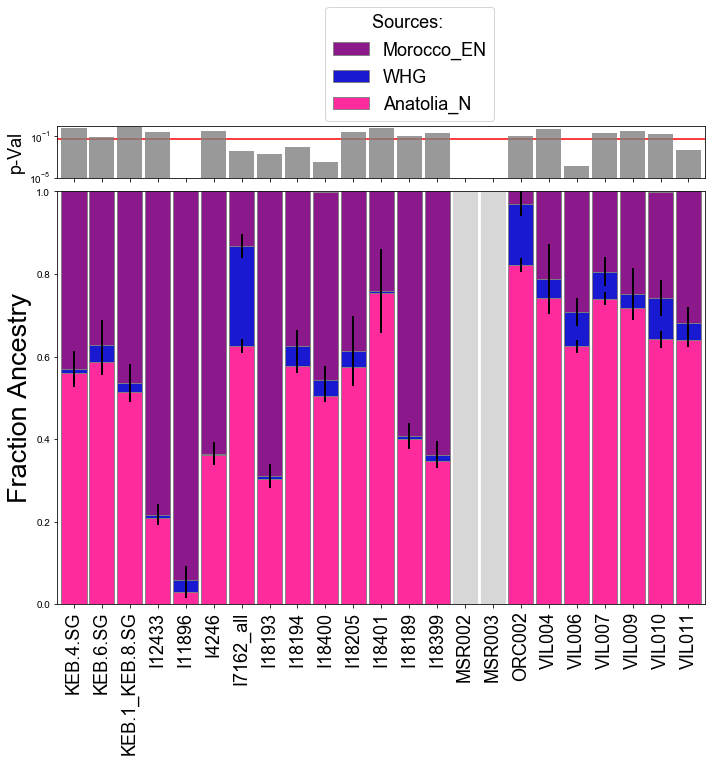

KEB.4.SG & Anatolia-N & WHG & Morocco-EN & A15 & \textbf{0.694} & 0.560 & 0.010 & 0.430 & 0.047 & 0.019 & 0.043\\
KEB.6.SG & Anatolia-N & WHG & Morocco-EN & A15 & \textbf{0.078} & 0.587 & 0.040 & 0.373 & 0.068 & 0.031 & 0.061\\
KEB.1-KEB.8.SG & Anatolia-N & WHG & Morocco-EN & A15 & \textbf{0.746} & 0.513 & 0.022 & 0.466 & 0.052 & 0.023 & 0.046\\
I12433 & Anatolia-N & WHG & Morocco-EN & A15 & \textbf{0.279} & 0.208 & 0.009 & 0.783 & 0.030 & 0.014 & 0.026\\
I11896 & Anatolia-N & WHG & Morocco-EN & A15 & $7.4\cdot10^{-8}$ & 0.028 & 0.031 & 0.941 & 0.037 & 0.014 & 0.033\\
I4246 & Anatolia-N & WHG & Morocco-EN & A15 & \textbf{0.332} & 0.361 & 0.003 & 0.636 & 0.032 & 0.013 & 0.028\\
I7162-all & Anatolia-N & WHG & Morocco-EN & A15 & $4.1\cdot10^{-3}$ & 0.626 & 0.242 & 0.132 & 0.031 & 0.017 & 0.030\\
I18193 & Anatolia-N & WHG & Morocco-EN & A15 & $2.1\cdot10^{-3}$ & 0.302 & 0.008 & 0.690 & 0.033 & 0.013 & 0.029\\
I18194 & Anatolia-N & WHG & Morocco-EN & A15 & $8.2\cdot10^{-3}$ & 0.577 & 0.048 

In [32]:
dir_path = "./output/qpAdm/3wayNAf/"
save_path = ""

#best=0, pval_lim = [1e-4,1], figsize=(6,6)

plot_qpadm(dir_path=dir_path, test_pops=paths, save_path=save_path, 
               best=False, pval_lim = [1e-5,1], figsize=(10,8), bw=0.9, ec="gray")

# Area 51

In [3]:
df_ind = pd.read_csv("./eigenstrat/combined/punic0.v43_mod.ind", delim_whitespace=True, header=None)
df_ind.columns=["iid", "sex","clst"]

In [4]:
df_ind

,iid,sex,clst
0,I3962,F,Israel_Persian
1,I4246_published,M,Iberia_BellBeaker_o_published
2,I2189,M,Israel_MLBA_Canaanite_o_brother.I2200
3,I2190,M,Israel_MLBA_Canaanite
4,I2195,M,Israel_MLBA_Canaanite
...,...,...,...
522,Tep002,F,Anatolia_Tepecik_Ciftlik
523,Tep003,M,Anatolia_Tepecik_Ciftlik
524,Tep004,F,Anatolia_Tepecik_Ciftlik
525,Tep006,M,Anatolia_Tepecik_Ciftlik
